In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function

import lightgbm as lgb
import numpy as np
import pandas as pd
import csv
import os

from astropy.io import fits

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, LabelEncoder

import matplotlib.pyplot as plt

from timeit import default_timer as timer

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, GlobalAveragePooling2D, Flatten, Dropout
from keras.optimizers import Adam, SGD, Adagrad, Adamax, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

import sdss_gz_data as sgd
from sdss_gz_data import SPIRIAL_GALAXY_TYPE
from sdss_gz_data import ELLIPTICAL_GALAXY_TYPE
from sdss_gz_data import UNKNOWN_GALAXY_TYPE
from sdss_gz_data import binnify

from joblib import Parallel, delayed

/Users/will/Development/Astronomy/proposal/ENV/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [3]:
N_FOLDS=5

In [5]:
features = sgd.generate_features()
features

['dered_u',
 'petroRad_u',
 'petroR50_u',
 'petroR90_u',
 'petro_R90_R50_ratio_u',
 'petroMag_u',
 'expRad_u',
 'deVRad_u',
 'psfMag_u',
 'expMag_u',
 'fiberMag_u',
 'extinction_u',
 'expAB_u',
 'expPhi_u',
 'deVAB_u',
 'deVPhi_u',
 'mag_u',
 'stokes_q_u',
 'stokes_u_u',
 'dered_g',
 'petroRad_g',
 'petroR50_g',
 'petroR90_g',
 'petro_R90_R50_ratio_g',
 'petroMag_g',
 'expRad_g',
 'deVRad_g',
 'psfMag_g',
 'expMag_g',
 'fiberMag_g',
 'extinction_g',
 'expAB_g',
 'expPhi_g',
 'deVAB_g',
 'deVPhi_g',
 'mag_g',
 'stokes_q_g',
 'stokes_u_g',
 'petro_g_u_colour_index',
 'model_g_u_colour_index',
 'psfMag_g_u_colour_index',
 'dered_i',
 'petroRad_i',
 'petroR50_i',
 'petroR90_i',
 'petro_R90_R50_ratio_i',
 'petroMag_i',
 'expRad_i',
 'deVRad_i',
 'psfMag_i',
 'expMag_i',
 'fiberMag_i',
 'extinction_i',
 'expAB_i',
 'expPhi_i',
 'deVAB_i',
 'deVPhi_i',
 'mag_i',
 'stokes_q_i',
 'stokes_u_i',
 'petro_i_r_colour_index',
 'model_i_r_colour_index',
 'psfMag_i_r_colour_index',
 'dered_r',
 'petroR

In [6]:
%ls -l data/

total 1660544
-rw-r--r--@ 1 will  staff  349816837 11 Mar 15:14 astromonical_data.csv.gz
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-g-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-i-000756-2-0427.fits
-rw-r--r--  1 will  staff   12208320  6 Apr 20:34 frame-r-000756-2-0427.fits
-rw-r--r--@ 1 will  staff  319952110 31 Jan 20:01 input.csv
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693755918.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756035.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756115.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756163.fits
-rw-r--r--  1 will  staff    4320000  6 Apr 20:34 obj-1237648720693756176.fits
-rw-r--r--  1 will  staff      58683 22 Apr 20:19 obj-1237650369407221944.fits.bz2
-rw-r--r--  1 will  staff   36904320  6 Apr 20:34 rgb-000756-2-0427.fits
-rw-r--r--  1 will  staff   12303360  6 Apr 20:34 rgb-000756-2-0427_2

In [4]:
selected_features = [
#     'deVAB_r',
#     'deVRad_g',
#     'dered_r',
#     'expAB_r',
#     'expMag_g',
#     'expRad_g',
#     'expRad_z',
#     'fiberMag_g',
#     'fiberMag_u',
#     'fracDeV_g',
#     'fracDeV_r',
#     'fracDeV_z',
#     'model_g_u_colour_index',
#     'model_i_r_colour_index',
#     'model_r_g_colour_index',
#     'model_z_i_colour_index',
#     'petroR50_i',
#     'petroRad_r',
#     'petro_R90_R50_ratio_g',
#     'petro_R90_R50_ratio_i',
#     'petro_r_g_colour_index',
#     'psfMag_g_u_colour_index',
#     'psfMag_i_r_colour_index',
#     'psfMag_r',
#     'psfMag_r_g_colour_index',
#     'psfMag_z_i_colour_index'

#     'deVAB_i',
#     'deVRad_i',
#     'expAB_g',
#     'expAB_i',
#     'expAB_z',
#     'expRad_g',
#     'expRad_i',
#     'expRad_u',
#     'expRad_z',
#     'fiberMag_g',
#     'fiberMag_r',
#     'fiberMag_u',
#     'fiberMag_z',
#     'mag_g',
#     'model_g_u_colour_index',
#     'model_i_r_colour_index',
#     'model_r_g_colour_index',
#     'model_z_i_colour_index',
#     'petroR50_i',
#     'petroR90_i',
#     'petroRad_r',
#     'petro_R90_R50_ratio_g',
#     'petro_R90_R50_ratio_i',
#     'petro_r_g_colour_index',
#     'psfMag_r'    

    'deVAB_i',
    'expAB_g',
    'expAB_i',
    'expAB_z',
    'expRad_g',
    'expRad_u',
    'expRad_z',
    'fiberMag_g',
    'fiberMag_u',
    'fiberMag_z',
    'model_g_u_colour_index',
    'model_i_r_colour_index',
    'model_r_g_colour_index',
    'model_z_i_colour_index',
    'dered_r',
    'petroRad_r',
    'petro_R90_R50_ratio_g',
    'petro_R90_R50_ratio_i',
    'petro_r_g_colour_index',
    'psfMag_r'    
]

In [21]:
orig_data = sgd.load_data('data/astromonical_data.csv.gz')

In [22]:
prepared_data = sgd.prepare_data(orig_data)

Number of high z galaxies = 231
Filtered out 3732 invalid records
% elliptical:      0.13576908942272356
% spiral:          0.2237143092857732
% unknown:         0.6405166012915032
% spiral of known: 0.6223216707350149


In [23]:
debiased_ind_selector = np.any([
    orig_data.debiased_spiral_ind == 1,
    orig_data.debiased_elliptical_ind == 1
], axis=0)

debiased_orig_data = orig_data[debiased_ind_selector]

In [24]:
debiased_prepared_data = sgd.prepare_data(debiased_orig_data)
debiased_prepared_data.loc[:,'galaxy_type'] = debiased_prepared_data['debiased_elliptical_ind']

Number of high z galaxies = 52
Filtered out 1294 invalid records
% elliptical:      0.24221037539629653
% spiral:          0.5544365016861533
% unknown:         0.20335312291755012
% spiral of known: 0.6959626876548608


In [25]:
#transformed_data = sgd.transform_data(prepared_data)
transformed_data = sgd.transform_data(debiased_prepared_data)

In [19]:
debiased_prepared_data.to_csv('debiased_prepared_data.csv.bz2')

In [18]:
selected_galaxies = np.all([
    transformed_data['z'] > 0.01,
    transformed_data['z'] < 0.2,
    transformed_data['model_r_g_colour_index'] < -1.75
], axis=0)

cols = ['objid', 'run', 'camcol', 'field', 'obj', 'model_r_g_colour_index', 'z']

transformed_data.iloc[selected_galaxies][cols].sort_values('model_r_g_colour_index')

,objid,run,camcol,field,obj,model_r_g_colour_index,z
48985,1237655504569696406,2335,6,47,150,-6.70177,0.107779
14548,1237650795681153153,1239,3,142,129,-6.14797,0.087771
52613,1237655472893788239,2328,3,39,79,-5.11422,0.129092
67023,1237658493360144414,3031,5,506,30,-4.58549,0.086674
191718,1237667781778014228,5194,2,723,20,-4.46707,0.037581
116604,1237663917880901725,4294,5,156,93,-4.44443,0.096900
122214,1237665127471513640,4576,2,468,40,-3.95981,0.153797
38246,1237654605854998587,2126,4,157,59,-3.87504,0.090552
33818,1237656242234393135,2507,4,109,559,-3.17493,0.153942
63028,1237657775010677270,2864,3,259,534,-3.00918,0.163301


In [26]:
X = transformed_data[selected_features]
y = transformed_data[['galaxy_type','z']]

In [27]:
len(transformed_data)

198084

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # sgd.split_train(X[selected_features], y, test_size=0.2, random_state=42, num_bins=16) #train_test_split(X[selected_features], y, test_size=0.2, random_state=42, stratify=y['galaxy_type'])
x_scaler = StandardScaler()
x_scaler.fit(X_train)
# X_train = x_scaler.fit_transform(X_train)
# X_test = x_scaler.transform(X_test)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
len(y_test)

39617

In [30]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train['galaxy_type']),
                                            y_train['galaxy_type'])
class_weights

array([0.67569054, 1.92295651])

In [41]:
from sdss_gz_data import redshift_err
from sdss_gz_data import z_err
from sdss_gz_data import z_err_stats

In [76]:
def create_nn(input_shape, dense_units=512, num_hidden_layers=1, lr=0.00003):
    input = Input(shape=input_shape, name='input_1')
    x = input
    
    for idx in range(num_hidden_layers - 1):
        x = Dense(dense_units,
                  kernel_initializer='he_normal',
                  name=f'hidden_layer_{idx + 1}',
                  use_bias=True,
                  kernel_regularizer=l2(),
                  activation='relu',
                 )(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)

    x = Dense(dense_units,
              kernel_initializer='he_normal',
              name=f'hidden_layer_{num_hidden_layers}',
              use_bias=True,
              kernel_regularizer=l2(),
              activation='relu',
             )(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output_1 = Dense(1, # classification
                     kernel_initializer='he_normal',
                     name='output_1',
                     use_bias=True,
                     activation='sigmoid', 
                     kernel_regularizer=l2(),
                    )(x)
    output_2 = Dense(1, # redshift regression
                     kernel_initializer='he_normal',
                     name='output_2',
                     use_bias=True,
                     activation='linear',
                     kernel_regularizer=l2(),
                    )(x)

    optimizer = Adam(lr=lr)
    
    model = Model(inputs=input, outputs=[output_1, output_2])
    loss_weights = { 'output_1': 1.0, 'output_2': 1.0 }
    model.compile(loss={'output_1': 'binary_crossentropy', 'output_2': redshift_err},
                  optimizer=optimizer,
                  loss_weights=loss_weights,
                  metrics={'output_1': 'accuracy', 'output_2': [redshift_err]}
                 )
    return model

model = create_nn((20,), num_hidden_layers=2, dense_units=512)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
hidden_layer_1 (Dense)          (None, 512)          10752       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 512)          2048        hidden_layer_1[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 512)          0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
hidden_lay

In [43]:
from keras.utils import plot_model
plot_model(model, to_file='images/ann_arch1.png', show_shapes=True, show_layer_names=True)

In [17]:
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)

def train(model, X_train, y_train, X_test, y_test, batch_size, epochs, callbacks=[], verbose=True):
    X_train = x_scaler.transform(X_train)
    X_test = x_scaler.transform(X_test)
    encoder = LabelEncoder()
    encoder.fit(y_train['galaxy_type'])
    y_train_galaxy = encoder.transform(y_train['galaxy_type'])
    y_train_z = y_train['z']
    
    y_test_galaxy = encoder.transform(y_test['galaxy_type'])
    y_test_z = y_test['z']
    
    history = model.fit(X_train, {'output_1': y_train_galaxy, 'output_2': y_train_z},
                batch_size=batch_size,
                epochs=epochs,
                verbose=verbose,
                validation_data=(X_test, {'output_1': y_test_galaxy, 'output_2': y_test_z}),
#                 class_weight={'output_1': class_weights},
                callbacks=callbacks)

    score = model.evaluate(X_test, {'output_1': y_test_galaxy, 'output_2': y_test_z}, verbose=0)
    print(score)
    print('Test loss        :', score[0])
    print('Test galaxy err  :', score[3])
    print('Test redshift err:', score[4])

    return score, history

In [18]:
def get_folds(X, y, n_splits=N_FOLDS, seed=None, num_bins=24):
    if n_splits == 1:
        # fake it by getting the first 80% as X
        idx = int(len(X) * .8)
        train_idx = np.arange(idx)
        validate_idx = np.arange(idx, len(X))
        return [(train_idx, validate_idx)]
    else:
        y_binned = binnify(y, num_bins=8)
        
        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(X, y_binned,)
        return folds

def kfolds(x_train,
           x_test,
           y_train,
           y_test,
           n_splits=N_FOLDS,
           random_state=1138,
           verbose=True,
           features=None,
           epochs=10,
           num_hidden_layers=2,
           dense_units=512,
           lr=0.00003
          ):
    if (features is not None):
        x_train = x_train[features]
        x_test = x_test[features]

    folds = get_folds(x_train, y_train, n_splits=n_splits, seed=random_state)
    oof_preds = np.zeros(x_train.shape[0])
    predictions = np.zeros(x_test.shape[0])
    
    earlystopping_callback = EarlyStopping(patience=3, restore_best_weights=True)
    callbacks = [earlystopping_callback]

    loss_val = 0
    error_val = 0
    models = np.empty(n_splits, dtype=Model)
    histories = np.empty(n_splits, dtype=object)

    for idx, (train_index, validate_index) in enumerate(folds):
        X_t, X_v = x_train.iloc[train_index], x_train.iloc[validate_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[validate_index]

        model = create_nn(
                (len(x_train.columns),),
                num_hidden_layers=num_hidden_layers,
                dense_units=dense_units,
                lr=lr,
            )

        if idx == 0:
            model.summary()

        score, history = train(model,
                X_t,
                y_t,
                X_v,
                y_v,
                batch_size=32,
                epochs=epochs,
                callbacks=callbacks
            )

        loss_val += score[0]
        error_val += score[1]
        print(f'Avg cross validation loss: {loss_val/(idx + 1)}')
        models[idx] = model
        histories[idx] = history

    return models, histories


In [80]:
models, histories = kfolds(X_train, X_test, y_train, y_test, epochs=30, num_hidden_layers=2, dense_units=512, lr=0.00001)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
hidden_layer_1 (Dense)          (None, 512)          10752       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 512)          2048        hidden_layer_1[0][0]             
__________________________________________________________________________________________________
dropout_49 (Dropout)            (None, 512)          0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
hidden_lay

Epoch 19/30
126769/126769 [==============================] - 53s 421us/step - loss: 0.6688 - output_1_loss: 0.0863 - output_2_loss: 0.0143 - output_1_acc: 0.9678 - output_2_redshift_err: 0.0143 - val_loss: 0.6094 - val_output_1_loss: 0.0717 - val_output_2_loss: 0.0112 - val_output_1_acc: 0.9735 - val_output_2_redshift_err: 0.0112
Epoch 20/30
126769/126769 [==============================] - 51s 399us/step - loss: 0.5897 - output_1_loss: 0.0849 - output_2_loss: 0.0141 - output_1_acc: 0.9680 - output_2_redshift_err: 0.0141 - val_loss: 0.5383 - val_output_1_loss: 0.0700 - val_output_2_loss: 0.0111 - val_output_1_acc: 0.9741 - val_output_2_redshift_err: 0.0111
Epoch 21/30
126769/126769 [==============================] - 51s 402us/step - loss: 0.5240 - output_1_loss: 0.0828 - output_2_loss: 0.0138 - output_1_acc: 0.9690 - output_2_redshift_err: 0.0138 - val_loss: 0.4820 - val_output_1_loss: 0.0712 - val_output_2_loss: 0.0109 - val_output_1_acc: 0.9737 - val_output_2_redshift_err: 0.0109
Epoc

Epoch 13/30
126772/126772 [==============================] - 40s 317us/step - loss: 2.0670 - output_1_loss: 0.0956 - output_2_loss: 0.0733 - output_1_acc: 0.9650 - output_2_redshift_err: 0.0733 - val_loss: 1.7578 - val_output_1_loss: 0.0758 - val_output_2_loss: 0.0150 - val_output_1_acc: 0.9712 - val_output_2_redshift_err: 0.0150
Epoch 14/30
126772/126772 [==============================] - 41s 325us/step - loss: 1.6091 - output_1_loss: 0.0946 - output_2_loss: 0.0435 - output_1_acc: 0.9649 - output_2_redshift_err: 0.0435 - val_loss: 1.3777 - val_output_1_loss: 0.0737 - val_output_2_loss: 0.0134 - val_output_1_acc: 0.9720 - val_output_2_redshift_err: 0.0134
Epoch 15/30
126772/126772 [==============================] - 41s 320us/step - loss: 1.2597 - output_1_loss: 0.0929 - output_2_loss: 0.0244 - output_1_acc: 0.9659 - output_2_redshift_err: 0.0244 - val_loss: 1.0982 - val_output_1_loss: 0.0758 - val_output_2_loss: 0.0124 - val_output_1_acc: 0.9708 - val_output_2_redshift_err: 0.0124
Epoc

Epoch 7/30
126774/126774 [==============================] - 42s 331us/step - loss: 7.3517 - output_1_loss: 0.1138 - output_2_loss: 0.3209 - output_1_acc: 0.9599 - output_2_redshift_err: 0.3209 - val_loss: 6.4369 - val_output_1_loss: 0.0842 - val_output_2_loss: 0.0572 - val_output_1_acc: 0.9696 - val_output_2_redshift_err: 0.0572
Epoch 8/30
126774/126774 [==============================] - 42s 329us/step - loss: 6.1102 - output_1_loss: 0.1092 - output_2_loss: 0.2717 - output_1_acc: 0.9609 - output_2_redshift_err: 0.2717 - val_loss: 5.3159 - val_output_1_loss: 0.0813 - val_output_2_loss: 0.0469 - val_output_1_acc: 0.9702 - val_output_2_redshift_err: 0.0469
Epoch 9/30
126774/126774 [==============================] - 42s 330us/step - loss: 5.0238 - output_1_loss: 0.1048 - output_2_loss: 0.2236 - output_1_acc: 0.9621 - output_2_redshift_err: 0.2236 - val_loss: 4.3447 - val_output_1_loss: 0.0799 - val_output_2_loss: 0.0381 - val_output_1_acc: 0.9712 - val_output_2_redshift_err: 0.0381
Epoch 1

Train on 126774 samples, validate on 31693 samples
Epoch 1/30
126774/126774 [==============================] - 45s 356us/step - loss: 20.0283 - output_1_loss: 0.2856 - output_2_loss: 0.7644 - output_1_acc: 0.8956 - output_2_redshift_err: 0.7644 - val_loss: 17.7872 - val_output_1_loss: 0.1414 - val_output_2_loss: 0.1896 - val_output_1_acc: 0.9587 - val_output_2_redshift_err: 0.1896
Epoch 2/30
126774/126774 [==============================] - 41s 323us/step - loss: 16.9223 - output_1_loss: 0.1749 - output_2_loss: 0.6417 - output_1_acc: 0.9464 - output_2_redshift_err: 0.6417 - val_loss: 15.0907 - val_output_1_loss: 0.1146 - val_output_2_loss: 0.1389 - val_output_1_acc: 0.9643 - val_output_2_redshift_err: 0.1389
Epoch 3/30
126774/126774 [==============================] - 41s 324us/step - loss: 14.4209 - output_1_loss: 0.1475 - output_2_loss: 0.5607 - output_1_acc: 0.9525 - output_2_redshift_err: 0.5607 - val_loss: 12.8648 - val_output_1_loss: 0.1020 - val_output_2_loss: 0.1146 - val_output_

126774/126774 [==============================] - 40s 319us/step - loss: 0.3641 - output_1_loss: 0.0792 - output_2_loss: 0.0136 - output_1_acc: 0.9700 - output_2_redshift_err: 0.0136 - val_loss: 0.3393 - val_output_1_loss: 0.0708 - val_output_2_loss: 0.0107 - val_output_1_acc: 0.9731 - val_output_2_redshift_err: 0.0107
Epoch 26/30
126774/126774 [==============================] - 40s 318us/step - loss: 0.3373 - output_1_loss: 0.0780 - output_2_loss: 0.0135 - output_1_acc: 0.9703 - output_2_redshift_err: 0.0135 - val_loss: 0.3163 - val_output_1_loss: 0.0715 - val_output_2_loss: 0.0105 - val_output_1_acc: 0.9730 - val_output_2_redshift_err: 0.0105
Epoch 27/30
126774/126774 [==============================] - 41s 322us/step - loss: 0.3149 - output_1_loss: 0.0776 - output_2_loss: 0.0135 - output_1_acc: 0.9708 - output_2_redshift_err: 0.0135 - val_loss: 0.2933 - val_output_1_loss: 0.0690 - val_output_2_loss: 0.0106 - val_output_1_acc: 0.9741 - val_output_2_redshift_err: 0.0106
Epoch 28/30
1267

Epoch 19/30
126779/126779 [==============================] - 41s 325us/step - loss: 0.6605 - output_1_loss: 0.0846 - output_2_loss: 0.0143 - output_1_acc: 0.9681 - output_2_redshift_err: 0.0143 - val_loss: 0.6079 - val_output_1_loss: 0.0764 - val_output_2_loss: 0.0110 - val_output_1_acc: 0.9707 - val_output_2_redshift_err: 0.0110
Epoch 20/30
126779/126779 [==============================] - 41s 322us/step - loss: 0.5826 - output_1_loss: 0.0834 - output_2_loss: 0.0140 - output_1_acc: 0.9690 - output_2_redshift_err: 0.0140 - val_loss: 0.5380 - val_output_1_loss: 0.0744 - val_output_2_loss: 0.0112 - val_output_1_acc: 0.9720 - val_output_2_redshift_err: 0.0112
Epoch 21/30
126779/126779 [==============================] - 42s 332us/step - loss: 0.5200 - output_1_loss: 0.0824 - output_2_loss: 0.0139 - output_1_acc: 0.9692 - output_2_redshift_err: 0.0139 - val_loss: 0.4821 - val_output_1_loss: 0.0742 - val_output_2_loss: 0.0110 - val_output_1_acc: 0.9722 - val_output_2_redshift_err: 0.0110
Epoc

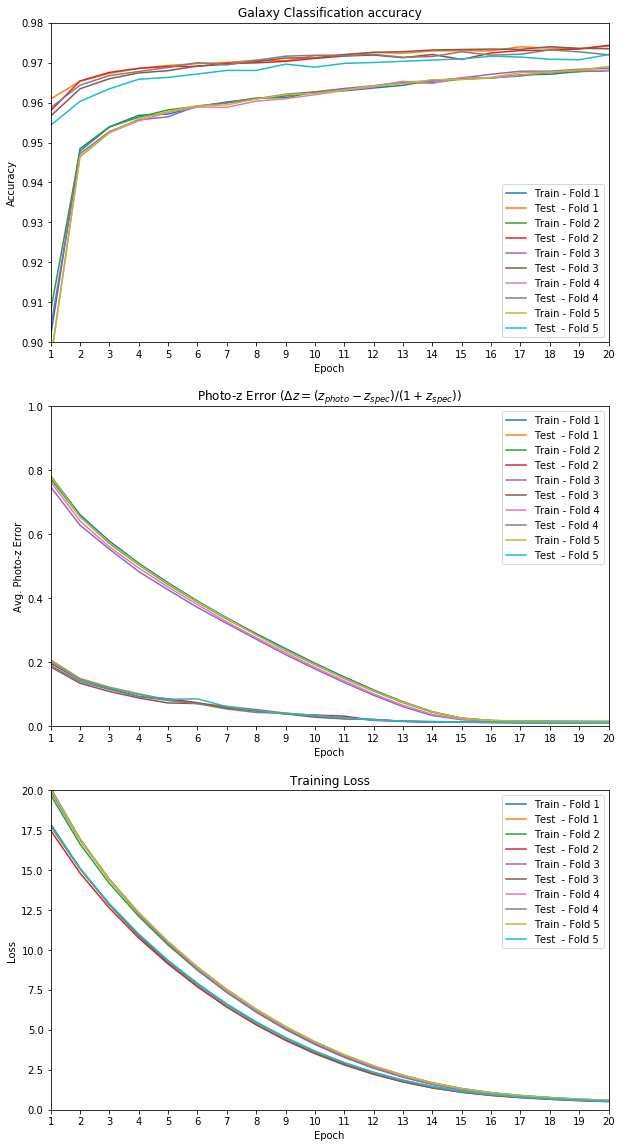

In [97]:
def plot_history(histories,
                 title,
                 train_id,
                 test_id,
                 ax,
                 axis,
                 log=False,
                 xlabel='Epoch',
                 ylabel='Accuracy',
                 legend_loc='lower right',
                 num_epochs=20,
                ):
    legend = np.empty(2 * len(histories), dtype=object)
#    plt.figure(figsize=(10,5))
    for idx, history in enumerate(histories):
        galaxy_acc = history.history[train_id][0:num_epochs]
        val_galaxy_acc = history.history[test_id][0:num_epochs]
        x = list(range(1,21))

        plt.plot(x, galaxy_acc)
        plt.plot(x, val_galaxy_acc)

        legend[2 * idx]     = f'Train - Fold {idx + 1}'
        legend[2 * idx + 1] = f'Test  - Fold {idx + 1}'

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if log:
        ax.set_yscale('log')
    ax.legend(legend, loc=legend_loc)
    ax.axis(axis)
    ax.set_xticks(x)
    
fig, ax = plt.subplots(3, 1, figsize=(10,20))
plot_history(histories,
             ax=plt.subplot(3, 1, 1),
             axis=[1, 20, 0.9, 0.98],
             title='Galaxy Classification accuracy',
             train_id='output_1_acc',
             test_id='val_output_1_acc',
             xlabel='Epoch',
             ylabel='Accuracy'
            )

plot_history(histories,
             ax=plt.subplot(3, 1, 2),
             axis=[1, 20, 0, 1.0],
             title=r'Photo-z Error ($\Delta{z} = (z_{photo} - z_{spec})/(1 + z_{spec})$)',
             train_id='output_2_redshift_err',
             test_id='val_output_2_redshift_err',
             xlabel='Epoch',
             ylabel='Avg. Photo-z Error',
             legend_loc='upper right',
            )

plot_history(histories,
             ax=plt.subplot(3, 1, 3),
             axis=[1, 20, 0, 20],
             title='Training Loss',
             train_id='loss',
             test_id='val_loss',
             xlabel='Epoch',
             ylabel='Loss',
             legend_loc='upper right'
            )

plt.show()

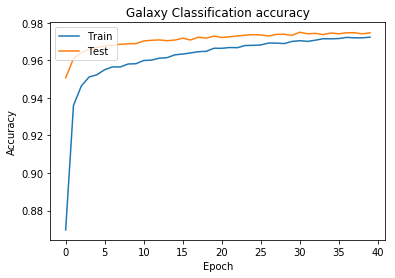

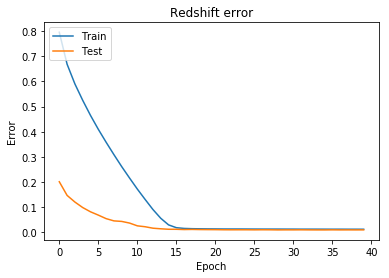

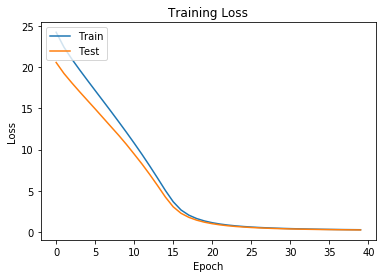

In [50]:
galaxy_acc = histories[0].history['output_1_acc']
val_galaxy_acc = histories[0].history['val_output_1_acc'][0:40]

plt.plot(galaxy_acc)
plt.plot(val_galaxy_acc)
plt.title('Galaxy Classification accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

redshift_err_ = histories[0].history['output_2_redshift_err'][0:40]
val_redshift_err = histories[0].history['val_output_2_redshift_err'][0:40]

plt.plot(redshift_err_)
plt.plot(val_redshift_err)
plt.title('Redshift error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

loss = histories[0].history['loss'][0:40]
val_loss = histories[0].history['val_loss'][0:40]

plt.plot(loss)
plt.plot(val_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [401]:
with open('ann_5_layers_256_units.h5', 'wb') as f:
    models.dump(f)

In [409]:
with open('ann_2_layers_512_units.h5', 'wb') as f:
    models.dump(f)

In [487]:
with open('ann_2_layers_512_units_new_split.h5', 'wb') as f:
    models.dump(f)

In [101]:
with open('ann_2_layers_512_units_new_split_lower_lr.h5', 'wb') as f:
    models.dump(f)

In [59]:
X_test_scale = x_scaler.transform(X_test)

predictions = np.zeros((len(models),) + y_test.shape)
for idx, model in enumerate(models):
    prediction = np.array(model.predict(X_test_scale))
    # move indexes around
    prediction = np.transpose(prediction)[0]
    predictions[idx] = prediction


In [489]:
X_test.to_csv('test_data_new_split.csv.bz2')
y_test.to_csv('test_y_new_split.csv.bz2')

In [490]:
X_train.to_csv('train_data_new_split.csv.bz2')
y_train.to_csv('train_y_new_split.csv.bz2')

In [491]:
with open('x_scaler_new_split.pkl', 'wb') as f:
    import pickle
    
    pickle.dump(x_scaler, f)

In [60]:
predictions_avg = np.mean(predictions, axis=0)
predictions_err = np.max(np.abs(predictions - predictions_avg), axis=0)
predictions_std = np.std(predictions, axis=0)
print(predictions_avg, predictions_std)

[[0.00082856 0.08237367]
 [0.00060353 0.07324279]
 [0.00036842 0.08903384]
 ...
 [0.08423972 0.15469849]
 [0.00125263 0.11685361]
 [0.00037608 0.09455162]] [[0.00031444 0.00182497]
 [0.00040478 0.00279941]
 [0.00022199 0.00095464]
 ...
 [0.02182771 0.00092926]
 [0.0004185  0.00423147]
 [0.00015826 0.00272719]]


In [61]:
galaxy_classification_preds = predictions.transpose()[0]
galaxy_classifications = np.count_nonzero(np.round(galaxy_classification_preds, 0), axis=1)
#print(galaxy_classifications, galaxy_classification_preds)

In [62]:
y_results = y_test.copy().reset_index()
y_results['galaxy_type_pred_raw'] = predictions_avg[:,0]
y_results['galaxy_type_pred_err'] = predictions_err[:,0]
y_results['galaxy_type_pred_std'] = predictions_std[:,0]
y_results['galaxy_type_pred'] = np.round(y_results.galaxy_type_pred_raw,0)
y_results['galaxy_type_pred'] = y_results['galaxy_type_pred'].astype(int, copy=False)
y_results['elliptical_votes'] = galaxy_classifications
y_results['galaxy_type_pred_votes'] = 0
y_results.loc[y_results.elliptical_votes >= 3, 'galaxy_type_pred_votes'] = 1
y_results['correct_votes'] = galaxy_classifications
y_results.loc[y_results.galaxy_type == 0,'correct_votes'] = 5 - y_results['correct_votes']
y_results['incorrect_votes'] = 5 - y_results['correct_votes']
y_results['photoz'] = predictions_avg[:,1]
y_results['photoz_err'] = (y_results['z'] - y_results['photoz'])/(1 + y_results['z'])
y_results['photoz_err_abs'] = np.abs(y_results['photoz_err'])
y_results['photoz_std'] = predictions_std[:,1]
y_results['galaxy_err'] = np.abs(y_results.galaxy_type - y_results.galaxy_type_pred_raw)

y_results

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std,galaxy_err
0,59796,0,0.085657,0.000829,0.000408,0.000314,0,0,0,5,0,0.082374,0.003024,0.003024,0.001825,0.000829
1,51749,0,0.062253,0.000604,0.000795,0.000405,0,0,0,5,0,0.073243,-0.010346,0.010346,0.002799,0.000604
2,160509,0,0.092705,0.000368,0.000370,0.000222,0,0,0,5,0,0.089034,0.003360,0.003360,0.000955,0.000368
3,99201,1,0.086126,0.987004,0.001739,0.001022,1,5,1,5,0,0.078862,0.006688,0.006688,0.002604,0.012996
4,95818,0,0.156180,0.003477,0.002645,0.001374,0,0,0,5,0,0.152992,0.002758,0.002758,0.001600,0.003477
5,136639,0,0.076505,0.000776,0.001112,0.000562,0,0,0,5,0,0.085253,-0.008126,0.008126,0.001658,0.000776
6,129229,0,0.184270,0.000640,0.000566,0.000297,0,0,0,5,0,0.170890,0.011299,0.011299,0.002201,0.000640
7,189706,0,0.123068,0.000811,0.000817,0.000427,0,0,0,5,0,0.105319,0.015804,0.015804,0.001638,0.000811
8,50746,0,0.085516,0.000535,0.000481,0.000273,0,0,0,5,0,0.071919,0.012526,0.012526,0.006531,0.000535
9,170827,0,0.111912,0.001615,0.001460,0.000812,0,0,0,5,0,0.107982,0.003534,0.003534,0.002941,0.001615


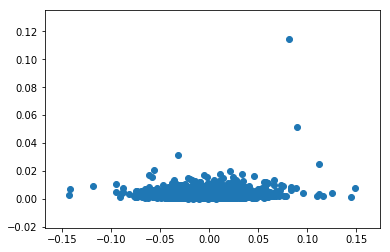

In [63]:
plt.scatter(predictions_avg[:,1] - y_results['z'], predictions_std[:, 1])

In [64]:
np.count_nonzero(np.round(predictions.transpose()[0],0),axis=1)[30:50]

array([0, 0, 0, 0, 5, 0, 5, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0])

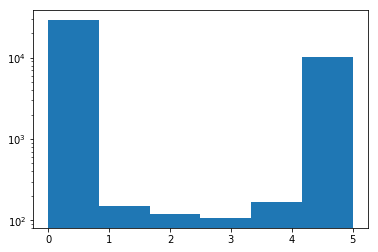

In [65]:
_ = plt.hist(galaxy_classifications, bins=6, log=True)

In [66]:
z_err_stats(y_test['z'], predictions_avg[:,1])

(0.009401617077021966,
 0.008689548529785289,
 1.59320333915431e-07,
 0.14913631541990918,
 0.0)

In [67]:
y_test[np.abs((y_test['z'] - predictions_avg[:,1])/(1 + y_test['z'])) > 0.15]

,galaxy_type,z


In [68]:
for i in range(16):
    min_range = 0.01 * i
    max_range = 0.01 * (i + 1)
    if (i == 15):
        max_range = 100.0

    selector = np.all([
        y_results.photoz_err_abs >= min_range,
        y_results.photoz_err_abs < max_range
    ], axis=0)
    num_of_records = len(y_results[selector])
    percentage = 100 * num_of_records / len(y_results)
    print(f'Z err between {min_range} and {max_range}: number = {num_of_records}, percentage = {percentage:0.2f}%')


Z err between 0.0 and 0.01: number = 25495, percentage = 64.35%
Z err between 0.01 and 0.02: number = 9950, percentage = 25.12%
Z err between 0.02 and 0.03: number = 2955, percentage = 7.46%
Z err between 0.03 and 0.04: number = 854, percentage = 2.16%
Z err between 0.04 and 0.05: number = 225, percentage = 0.57%
Z err between 0.05 and 0.06: number = 89, percentage = 0.22%
Z err between 0.06 and 0.07: number = 24, percentage = 0.06%
Z err between 0.07 and 0.08: number = 11, percentage = 0.03%
Z err between 0.08 and 0.09: number = 3, percentage = 0.01%
Z err between 0.09 and 0.1: number = 2, percentage = 0.01%
Z err between 0.1 and 0.11: number = 2, percentage = 0.01%
Z err between 0.11 and 0.12: number = 4, percentage = 0.01%
Z err between 0.12 and 0.13: number = 1, percentage = 0.00%
Z err between 0.13 and 0.14: number = 0, percentage = 0.00%
Z err between 0.14 and 0.15: number = 2, percentage = 0.01%
Z err between 0.15 and 100.0: number = 0, percentage = 0.00%


In [69]:
np.max(y_results.photoz_err_abs)

0.14913631541990918

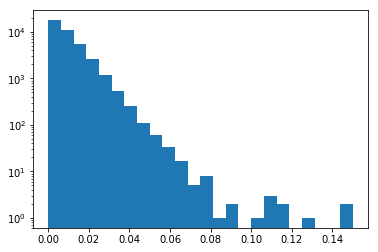

In [71]:
bins = np.linspace(0, 0.15, num=25)
_ = plt.hist(y_results.photoz_err_abs, bins=bins, log=True)

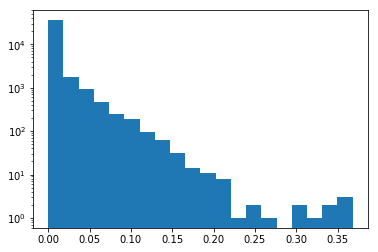

In [72]:
_ = plt.hist(y_results.galaxy_type_pred_std, bins=20, log=True)

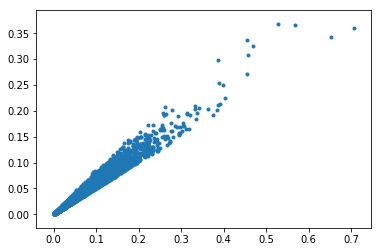

In [73]:
plt.scatter(y_results.galaxy_type_pred_err, y_results.galaxy_type_pred_std, marker='.')

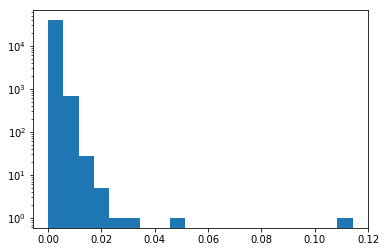

In [74]:
_ = plt.hist(y_results.photoz_std, bins=20, log=True)

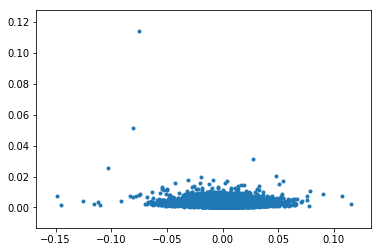

In [75]:
plt.scatter(y_results[y_results.photoz_err_abs < 0.15].photoz_err, y_results[y_results.photoz_err_abs < 0.15].photoz_std, marker='.')

In [505]:
y_results[y_results.photoz_err_abs > 0.10]

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std
5435,1328,1,0.317921,0.596033,0.236537,0.151756,1,3,1,3,2,0.177575,0.106490,0.106490,0.003626
5765,126501,0,-0.000133,0.032557,0.012994,0.008345,0,0,0,5,0,0.145660,-0.145813,0.145813,0.002984
9152,114325,0,-0.000008,0.003281,0.001841,0.001212,0,0,0,5,0,0.106168,-0.106177,0.106177,0.001909
10447,177280,0,-0.000066,0.005375,0.003445,0.002884,0,0,0,5,0,0.118824,-0.118898,0.118898,0.004387
12747,67023,0,0.086674,0.615387,0.592127,0.470022,1,3,1,2,3,0.329778,-0.223714,0.223714,0.172919
15975,183308,1,-0.000062,0.992785,0.002334,0.001422,1,5,1,5,0,0.137797,-0.137868,0.137868,0.010934
21255,21938,1,0.000330,0.446908,0.134877,0.098408,0,2,0,2,3,0.115346,-0.114979,0.114979,0.002969
21866,9368,0,0.113812,0.676434,0.579134,0.391993,1,3,1,2,3,0.241100,-0.114282,0.114282,0.069755
24027,143251,0,0.004621,0.000095,0.000062,0.000035,0,0,0,5,0,0.117832,-0.112691,0.112691,0.003776
25078,31469,0,0.237789,0.000162,0.000085,0.000059,0,0,0,5,0,0.092997,0.116976,0.116976,0.002039


In [76]:
y_results[y_results.galaxy_err > 0.8].sort_values(['galaxy_err', 'photoz_err'], ascending=False)

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std,galaxy_err
29621,113781,1,0.052153,0.000045,0.000027,0.000016,0,0,0,0,5,0.082627,-0.028963,0.028963,0.003266,0.999955
25910,196959,1,0.089201,0.001305,0.000778,0.000636,0,0,0,0,5,0.123539,-0.031526,0.031526,0.001474,0.998695
32198,53279,1,0.028300,0.001785,0.002024,0.001124,0,0,0,0,5,0.065047,-0.035735,0.035735,0.003060,0.998215
17893,161775,0,0.207895,0.998192,0.001087,0.000701,1,5,1,0,5,0.217903,-0.008286,0.008286,0.001753,0.998192
19023,119083,0,0.083705,0.997964,0.000376,0.000222,1,5,1,0,5,0.102268,-0.017129,0.017129,0.003999,0.997964
19872,185235,0,0.033233,0.997390,0.003492,0.001767,1,5,1,0,5,0.049258,-0.015509,0.015509,0.007068,0.997390
28843,146330,0,0.104719,0.997037,0.002135,0.001081,1,5,1,0,5,0.039426,0.059103,0.059103,0.002629,0.997037
20852,174928,1,0.073935,0.003127,0.002878,0.002048,0,0,0,0,5,0.102357,-0.026465,0.026465,0.004884,0.996873
3641,167085,1,0.136056,0.003649,0.001886,0.001400,0,0,0,0,5,0.134880,0.001035,0.001035,0.003658,0.996351
14440,50858,0,0.099626,0.994497,0.001567,0.000899,1,5,1,0,5,0.101944,-0.002108,0.002108,0.004233,0.994497


In [77]:
y_results[y_results.galaxy_type - y_results.galaxy_type_pred != 0].sort_values('galaxy_err', ascending=False)

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std,galaxy_err
29621,113781,1,0.052153,0.000045,0.000027,0.000016,0,0,0,0,5,0.082627,-0.028963,0.028963,0.003266,0.999955
25910,196959,1,0.089201,0.001305,0.000778,0.000636,0,0,0,0,5,0.123539,-0.031526,0.031526,0.001474,0.998695
32198,53279,1,0.028300,0.001785,0.002024,0.001124,0,0,0,0,5,0.065047,-0.035735,0.035735,0.003060,0.998215
17893,161775,0,0.207895,0.998192,0.001087,0.000701,1,5,1,0,5,0.217903,-0.008286,0.008286,0.001753,0.998192
19023,119083,0,0.083705,0.997964,0.000376,0.000222,1,5,1,0,5,0.102268,-0.017129,0.017129,0.003999,0.997964
19872,185235,0,0.033233,0.997390,0.003492,0.001767,1,5,1,0,5,0.049258,-0.015509,0.015509,0.007068,0.997390
28843,146330,0,0.104719,0.997037,0.002135,0.001081,1,5,1,0,5,0.039426,0.059103,0.059103,0.002629,0.997037
20852,174928,1,0.073935,0.003127,0.002878,0.002048,0,0,0,0,5,0.102357,-0.026465,0.026465,0.004884,0.996873
3641,167085,1,0.136056,0.003649,0.001886,0.001400,0,0,0,0,5,0.134880,0.001035,0.001035,0.003658,0.996351
14440,50858,0,0.099626,0.994497,0.001567,0.000899,1,5,1,0,5,0.101944,-0.002108,0.002108,0.004233,0.994497


In [78]:
unsure_classification = np.all([
    y_results.incorrect_votes >= 2,
    y_results.incorrect_votes <= 3
], axis=0)

y_results[unsure_classification].sort_values('galaxy_err', ascending=False)

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std,galaxy_err
19818,78520,0,0.116232,0.659749,0.254562,0.173597,1,3,1,2,3,0.119736,-0.003139,0.003139,0.006933,0.659749
37835,109633,0,0.059009,0.636970,0.261217,0.207328,1,3,1,2,3,0.042646,0.015452,0.015452,0.002801,0.636970
9178,181442,0,0.041701,0.618705,0.165619,0.137453,1,3,1,2,3,0.059194,-0.016793,0.016793,0.003475,0.618705
38062,83616,1,0.187153,0.394248,0.170721,0.106409,0,2,0,2,3,0.180729,0.005411,0.005411,0.003340,0.605752
32732,58011,1,0.058694,0.404554,0.215173,0.152625,0,2,0,2,3,0.052250,0.006087,0.006087,0.001149,0.595446
18762,133966,0,0.210166,0.595095,0.297436,0.169324,1,3,1,2,3,0.199633,0.008704,0.008704,0.009541,0.595095
22268,126058,0,0.036740,0.591148,0.233116,0.171810,1,3,1,2,3,0.030838,0.005692,0.005692,0.003981,0.591148
17172,66400,0,0.059938,0.581192,0.119380,0.089059,1,3,1,2,3,0.055748,0.003954,0.003954,0.001086,0.581192
14186,145015,0,0.157312,0.578630,0.199087,0.132985,1,3,1,2,3,0.196837,-0.034152,0.034152,0.004350,0.578630
30488,137598,1,0.105351,0.426447,0.190156,0.107102,0,2,0,2,3,0.088082,0.015623,0.015623,0.003660,0.573553


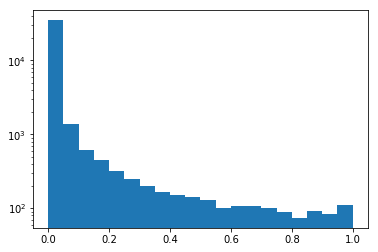

In [79]:
_ = plt.hist(y_results['galaxy_err'], bins=20, log=True)

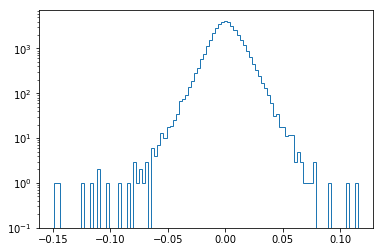

In [80]:
_ = plt.hist(y_results['photoz_err'], histtype='step', log=True, bins=100)

NameError: name 'y_results' is not defined

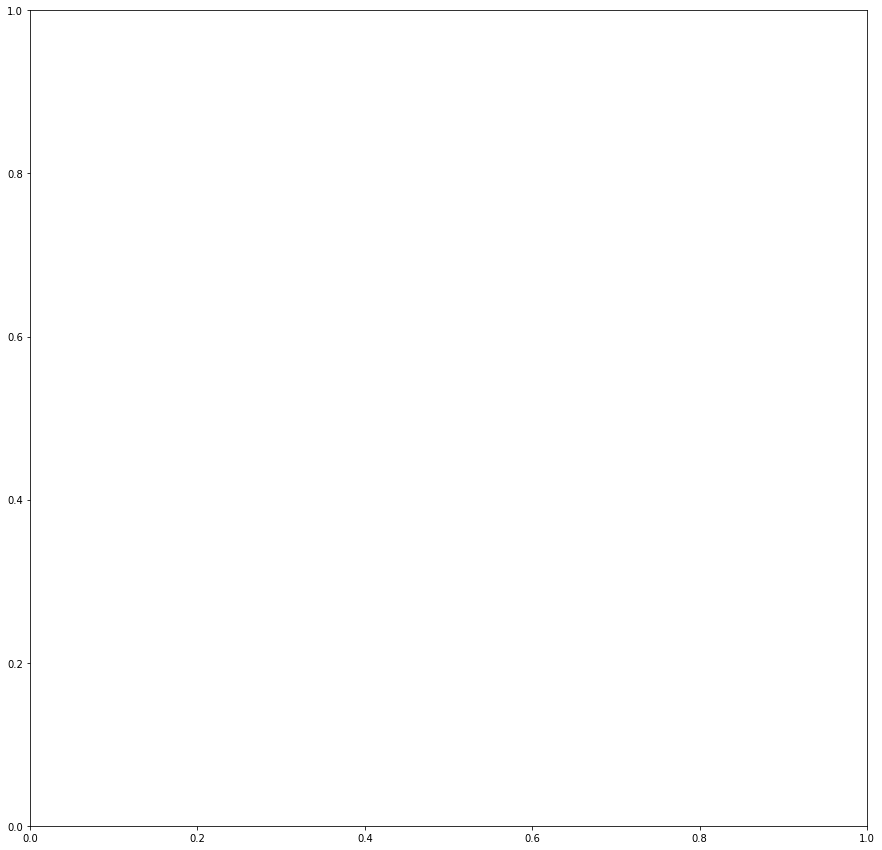

In [81]:
fig, ax = plt.subplots(figsize=(15,15))

lin = np.linspace(np.min(y_results['z']), np.max(y_results['z']), 100)

ax.scatter(y_results['z'], y_results['photoz'], marker='.')
_ = ax.plot(lin, lin, c= "red")

In [104]:
sgd.z_pop_std(y_results['z'], y_results['photoz'])

0.014274122125977026

In [82]:
non_outlier = y_results.photoz_err_abs < 0.1

fig, ax = plt.subplots(figsize=(15,15))

lin = np.linspace(np.min(y_results['z']), np.max(y_results['z']), 100)

ax.scatter(y_results['z'][non_outlier], y_results['photoz'][non_outlier], marker='.')
_ = ax.plot(lin, lin, c= "red")

NameError: name 'y_results' is not defined

In [83]:
sgd.classification_scores(y_results['galaxy_type'], y_results['galaxy_type_pred'])

[[28682   550]
 [  445  9940]]


{'recall': 0.9571497351949928,
 'specificity': 0.9811850027367269,
 'precision': 0.9475691134413727,
 'accuracy': 0.9748845192720297,
 'f1': 0.9523353293413174,
 'mcc': 0.9353080839464285}

In [84]:
sgd.classification_scores(y_results['galaxy_type'], y_results.galaxy_type_pred_votes)

[[28684   548]
 [  437  9948]]


{'recall': 0.9579200770341839,
 'specificity': 0.9812534209085934,
 'precision': 0.9477896341463414,
 'accuracy': 0.9751369361637681,
 'f1': 0.9528279296968536,
 'mcc': 0.9359729361263599}

In [85]:
roc_auc_score(y_results.galaxy_type, y_results.galaxy_type_pred_raw)

0.9966331523035281

In [399]:
y_results.sort_values(['galaxy_err', 'photoz_err'])

,index,galaxy_type,z,galaxy_type_pred_raw,galaxy_type_pred_err,galaxy_type_pred_std,galaxy_type_pred,elliptical_votes,galaxy_type_pred_votes,correct_votes,incorrect_votes,photoz,photoz_err,photoz_err_abs,photoz_std,galaxy_err
9725,43428,1,0.325491,0.999998,0.000004,0.000002,1,5,1,5,0,0.323466,0.001528,0.001528,0.007381,0.000002
14569,5570,0,0.162296,0.000004,0.000016,0.000008,0,0,0,5,0,0.008564,0.132265,0.132265,0.026516,0.000004
34305,93249,1,0.318784,0.999994,0.000006,0.000004,1,5,1,5,0,0.313057,0.004343,0.004343,0.010539,0.000006
5277,110500,1,0.315178,0.999992,0.000016,0.000009,1,5,1,5,0,0.296252,0.014390,0.014390,0.009682,0.000008
912,78301,1,0.288408,0.999991,0.000025,0.000012,1,5,1,5,0,0.286611,0.001395,0.001395,0.006913,0.000009
21074,39824,1,0.350117,0.999989,0.000034,0.000017,1,5,1,5,0,0.343727,0.004733,0.004733,0.013611,0.000011
17161,128285,1,0.308910,0.999975,0.000034,0.000021,1,5,1,5,0,0.317295,-0.006406,0.006406,0.010890,0.000025
2384,143205,1,0.329246,0.999975,0.000016,0.000013,1,5,1,5,0,0.303933,0.019044,0.019044,0.006979,0.000025
22083,49926,1,0.301581,0.999972,0.000041,0.000025,1,5,1,5,0,0.299436,0.001648,0.001648,0.007236,0.000028
36317,6662,1,0.322028,0.999971,0.000048,0.000027,1,5,1,5,0,0.311073,0.008287,0.008287,0.008397,0.000029


In [87]:
other_featuers = [
    'objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'ra', 'dec', 'petroRad_r', 'z', 'galaxy_type'
]
# 	galaxy_type	z
# 48985	0	0.107779
# 116604	0	0.096900
# 191718	0	0.037581
all_features = selected_features + other_featuers

In [88]:
gz_features = [
    'votes',
    'elliptical',
    'spiralclock',
    'spiralanticlock',
    'edgeon',
    'spiralanticlock',
    'merger',
    'debiased_elliptical',
    'debiased_spiral',
    'debiased_spiral_ind',
    'debiased_elliptical_ind',
    'debiased_uncertain_ind'
]

In [89]:
orig_data[orig_data.objid == '1237655504569696406'][gz_features].T

,138095
votes,31.000
elliptical,0.613
spiralclock,0.065
spiralanticlock,0.000
edgeon,0.290
spiralanticlock,0.000
merger,0.000
debiased_elliptical,0.188
debiased_spiral,0.755
debiased_spiral_ind,1.000


In [90]:
prepared_data[prepared_data.objid == '1237655504569696406'][all_features].T

,136853
deVAB_i,0.579477
expAB_g,0.294724
expAB_i,0.625691
expAB_z,0.543647
expRad_g,30.6919
expRad_u,34.4684
expRad_z,1.21549
fiberMag_g,19.4786
fiberMag_u,20.9683
fiberMag_z,17.9712


In [166]:
orig_data[orig_data.objid == '1237663917880901725'][gz_features]

,votes,elliptical,spiralclock,spiralanticlock,edgeon,spiralanticlock,merger,debiased_elliptical,debiased_spiral,debiased_spiral_ind,debiased_elliptical_ind,debiased_uncertain_ind
321151,33,0.061,0.03,0.788,0.121,0.788,0.0,0.034,0.966,1,0,0


In [170]:
prepared_data[prepared_data.objid == '1237663917880901725'][all_features].T

,318798
deVAB_i,0.426645
expAB_g,0.341788
expAB_i,0.438888
expAB_z,0.459927
expRad_g,0.00122078
expRad_u,0.00131318
expRad_z,2.91558
fiberMag_g,19.4274
fiberMag_u,21.2713
fiberMag_z,17.316


In [91]:
prepared_data.objid = prepared_data.objid.astype(str)
prepared_data.run = prepared_data.run.astype(int)
prepared_data.rerun = prepared_data.rerun.astype(int)
prepared_data.camcol = prepared_data.camcol.astype(int)
prepared_data.field = prepared_data.field.astype(int)
prepared_data.obj = prepared_data.obj.astype(int)
prepared_data.dtypes

objid                       object
run                          int64
rerun                        int64
camcol                       int64
field                        int64
obj                          int64
ra                         float64
dec                        float64
clean                        int64
petroRad_u                 float64
petroRad_g                 float64
petroRad_r                 float64
petroRad_i                 float64
petroRad_z                 float64
petroRadErr_u              float64
petroRadErr_g              float64
petroRadErr_r              float64
petroRadErr_i              float64
petroRadErr_z              float64
petroR50_u                 float64
petroR50_g                 float64
petroR50_r                 float64
petroR50_i                 float64
petroR50_z                 float64
petroR90_u                 float64
petroR90_g                 float64
petroR90_r                 float64
petroR90_i                 float64
petroR90_z          

## Hyperparameter Search

In [ ]:
from hyperopt import fmin
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
N_FOLDS = 5
ITERATION = 0

hp_out_file = 'gbm_hp_trials.csv'
of_connection = open(hp_out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

def objective(x_train, y_train, random_state=42, stratified=True):    
    def _objective(params, n_folds=N_FOLDS):
        # Keep track of evals
        global ITERATION
        
        print(params)

        ITERATION += 1

        # 1. Create + compile model
        params['dense_units'] = int(params['dense_units'])
        params['batch_size'] = int(params['batch_size'])
        params['input_shape'] = (x_train.shape[1],)
        params['output_shape'] = 1
        callbacks = [EarlyStopping(monitor='mean_squared_error', patience=2)]
        
        model = KerasRegressor(build_fn=create_nn, verbose=0, epochs=100, **params)
        
        # 2. Do Cross Validation
        
        start = timer()
        cv = ShuffleSplit(n_splits=n_folds, test_size=0.2, random_state=random_state)
        scores = cross_val_score(model, x_train, y_train, cv=cv, fit_params={'callbacks': callbacks })
        run_time = timer() - start

        loss = max(scores)

        # Round that returned the highest cv score
        n_estimators = int(np.argmax(scores) + 1)

        if ITERATION % 10 == 0:
            # Display the information
            display('Iteration {}: {} Fold CV Loss {:.5f}'.format(ITERATION, N_FOLDS, loss))

        of_connection = open(hp_out_file, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, params, ITERATION, n_estimators, run_time])
        of_connection.close()

        # Dictionary with information for evaluation
        return {'loss': loss, 'params': params, 'iteration': ITERATION,
                'estimators': n_estimators, 
                'train_time': run_time, 'status': STATUS_OK}

    return _objective

In [ ]:
space = {
    'dense_units': hp.choice('dense_units', [128, 256, 512, 1024, 2028]),
    'lr': hp.loguniform('lr', np.log(0.00001), np.log(0.1)),
    'dropout_rate_1': hp.choice('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5]),
    'l2_reg': hp.uniform('l1_reg', 0.0, 1.0),
    'batch_size': hp.quniform('batch_size', 10, 100, 20),
}


In [ ]:
MAX_EVALS = 100

tpe_algorithm = tpe.suggest
bayes_trials = Trials()

best = fmin(fn = objective(X_train_norm, y_train_norm), space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate=np.random.RandomState(1138))

In [ ]:
bayes_trials.best_trial['result']

In [ ]:
model = create_nn((X.shape[1],), 1, dense_units=2028, l2_reg=0.964981502445198, dropout_rate_1=0.2, lr=0.00001)
model.summary()

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.reset_states()
model.fit(X_train_norm, y_train_norm, epochs=100, batch_size=100, callbacks=callbacks, validation_split=0.2)

In [ ]:
X = np.random.uniform(size=(1,4))
X

In [ ]:
y = [0.5]

In [ ]:
input_layer = Input(shape=(X_train_norm.shape[1],), name='input_1')
output_layer = Dense(1)(input_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adagrad')
model.summary()

model.fit(X_train_norm[0:1], y_train_norm[0], epochs=100)

In [ ]:
y_train_norm[0]

In [ ]:
model.predict(X_train_norm[0:1])

In [ ]:
K.epsilon()

In [ ]:
y_norm = y_scaler.fit_transform(y.reshape(-1, 1))
y_scaler.lambdas_

In [ ]:
np.min(y_norm), np.max(y_norm)

In [ ]:
bins = np.linspace(-3, 3, 11) 
bins

In [ ]:
y_binned = np.digitize(y_norm, bins)
y_binned

In [ ]:
y_binned.shape

In [ ]:
bincount = np.bincount(y_binned.ravel())
bincount

In [ ]:
plt.plot(bincount)

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True) 
for train_idx, test_idx in skf.split(X, y_binned):
#     X_train = X.iloc[train_idx,:]
#     y_train = y[train_idx]
    print(train_idx.shape, test_idx.shape)


In [ ]:
X = X.reindex()

In [232]:
debiased_prepared_data[['galaxy_type','debiased_spiral_ind','debiased_elliptical_ind']]

,galaxy_type,debiased_spiral_ind,debiased_elliptical_ind
0,1,0,1
1,0,1,0
2,0,1,0
3,1,0,1
4,0,1,0
5,0,1,0
6,1,0,1
7,0,1,0
8,0,1,0
9,0,1,0


In [528]:
db_y_train = debiased_prepared_data[['galaxy_type', 'z']]
class_weight = class_weight.compute_class_weight('balanced',
                                            np.unique(db_y_train['galaxy_type']),
                                            db_y_train['galaxy_type'])
weights

array([0.67607768, 1.91982787])

In [530]:
len(y_train)

158467

In [531]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train['galaxy_type']),
                                            y_train['galaxy_type'])
weights

array([0.67569054, 1.92295651])

In [529]:
len(db_y_train[db_y_train.galaxy_type == 0]), len(db_y_train[db_y_train.galaxy_type == 1])

(146495, 51589)

In [112]:
weighted_models = models.copy()
weighted_models

array([<keras.engine.training.Model object at 0x13e4c8ef0>,
       <keras.engine.training.Model object at 0x1388c4ac8>], dtype=object)

In [93]:
def feature_stats(feature, transform=lambda x: x):
    records = prepared_data[feature].apply(transform)
    _ = plt.hist(records, log=True, bins=100)
    
    print(np.min(records), np.max(records), np.mean(records), np.std(records), np.median(records))

1.248781202695082e-05 4.10009913950256 1.1905238662548931 0.4026378399190581 1.1101516204167936


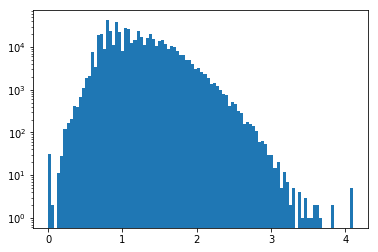

In [94]:
feature_stats('expRad_g', transform=np.log1p)

0.0006055338273810418 3.940873401469453 1.1417301198956489 0.37952031325916297 1.0725357313677526


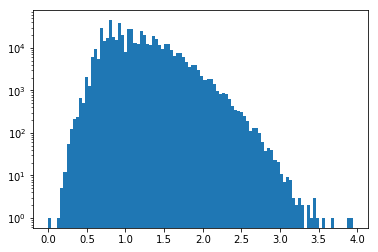

In [95]:
feature_stats('expRad_r', transform=np.log1p)

0.00015349181952794134 4.100081408340614 1.0337760000499088 0.3683382290058709 0.9431038263599909


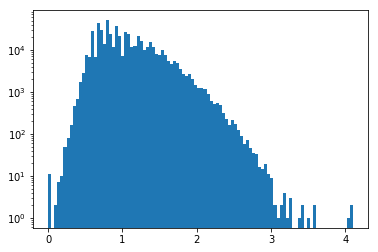

In [96]:
feature_stats('expRad_z', transform=np.log1p)

0.0007723750415876469 3.4236976741748624 1.551517378420959 0.5725677930916816 1.4559022767595344


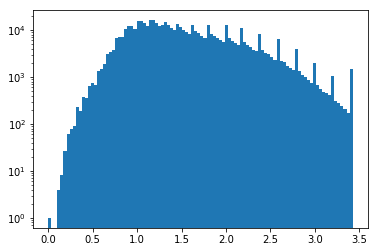

In [97]:
feature_stats('deVRad_r', transform=np.log1p)

-0.5584808333333333 0.059781666666666844 -0.06951417471668679 0.021382366332933535 -0.07119583333333335


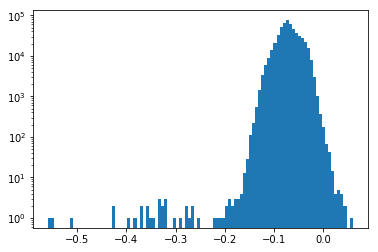

In [98]:
feature_stats('model_r_g_colour_index', transform=lambda x: x ** 1/12)

In [99]:
X_test.sort_values(by='model_r_g_colour_index')

,deVAB_i,expAB_g,expAB_i,expAB_z,expRad_g,expRad_u,expRad_z,fiberMag_g,fiberMag_u,fiberMag_z,model_g_u_colour_index,model_i_r_colour_index,model_r_g_colour_index,model_z_i_colour_index,dered_r,petroRad_r,petro_R90_R50_ratio_g,petro_R90_R50_ratio_i,petro_r_g_colour_index,psfMag_r
67023,0.262874,0.050000,0.345267,0.359870,0.007785,1.301911,0.910410,20.06891,22.18381,18.00562,1.41401,-0.50384,-4.58549,-0.29489,17.87664,1.224520,0.391340,1.059796,-5.22439,19.26102
9368,0.744180,0.751731,0.770071,0.765281,1.839153,1.942634,1.599798,20.77900,20.69842,17.58371,0.29397,-0.36304,-2.29106,-0.20962,15.89852,2.248317,0.584880,0.749058,-2.35041,18.44058
19373,0.546609,0.702408,0.581322,0.672047,0.991004,1.838688,0.982353,21.08519,22.97497,18.18670,-1.53780,-0.62316,-1.83960,-0.41132,17.56447,1.844211,0.758128,1.135126,-2.27024,19.14082
27858,0.242648,0.122174,0.323087,0.050000,0.833677,3.814202,0.402651,19.97237,21.77492,17.77652,-5.10263,-0.46663,-1.82377,1.05993,17.54037,1.230993,1.092667,1.116628,-2.06250,18.87974
91690,0.693989,0.687835,0.708410,0.703997,1.322824,2.094447,1.335489,21.38036,23.52422,18.61999,-1.88389,-0.57861,-1.81127,-0.37683,17.28806,2.084699,0.970576,1.056910,-1.98427,20.06681
193769,0.845673,0.907544,0.783483,0.783425,0.905429,4.100081,0.796979,21.06592,23.37604,18.27695,-2.02966,-0.65184,-1.79656,-0.31726,17.74846,1.850549,1.043809,1.141088,-1.85889,19.48542
93249,0.763797,0.783347,0.782458,0.785480,0.964759,2.285044,0.917721,20.62757,23.68530,17.82925,-2.88185,-0.59814,-1.78801,-0.33110,17.01908,2.001635,0.987303,1.011885,-2.01483,18.70547
6939,0.737230,0.786874,0.712339,0.838290,1.530812,1.803228,1.262398,20.05758,20.96789,17.44002,-0.87399,-0.41681,-1.77486,-0.33613,16.04089,2.114450,0.662992,0.884178,-1.79941,18.21869
124368,0.716959,0.766925,0.728707,0.638882,0.816004,4.099914,0.810965,20.92051,22.51261,18.13973,-2.30751,-0.58885,-1.76913,-0.40740,17.71233,1.922677,1.010950,1.299618,-1.85175,19.07890
103676,0.756707,0.704102,0.792294,0.827008,1.039216,2.556751,0.936926,20.99777,23.09790,18.24806,-2.31171,-0.61644,-1.76575,-0.34680,17.63640,1.922197,0.830818,1.180630,-2.04951,19.12017


In [260]:
# 48985	0	0.107779
# 116604	0	0.096900
# 191718	0	0.037581